# Process EMG

This script is going to
- Load in sample data
- Apply a continuous, causal FIR 0.1 high-pass filter (viable in true real-time)
- Epoch the data in large chunks
- Generate averaged figures
- Export data for ML team

In [272]:
import numpy as np
import ezbci_lite as ez
from scipy import signal
import copy
import matplotlib.pyplot as plt
import json
import pyxdf

## Step 1: Load the data

We'll load the XDF data (extensible data format; LSL-recorded format made at the SCCN right here at UCSD).

We have three different streams
- EEG (which is actually EMG)
- AUX (which may contain useful accelerometer data, but will be ignored currently)
- Marker (which contains which events occurred and when)

In [273]:
fname = 'data/data.xdf'
raw_EMG = ez.loadxdf(fname)

This returns a dictionary with the following keys:
- ```eeg_data``` (num. samples $\times$ num. channels): contains the time series voltage changes across all channels
- ```eeg_time``` (num. samples): contains time points sampled by LSL for each corresponding time series datum
- ```event_data``` (num. events): contains nested list-strings denoting individual events
- ```event_time``` (num. events): contains time points for each individual event
- ```channels``` (num. channels): contains dict of channel labels as keys and channel index as value
- ```fs``` (float): current sampling rate
- ```fs_i``` (float): initial sampling rate -- this should never change

Let's delete channels 4+ since we only recorded 3 channels of EMG. Let's also update the channels since the default montage used by OpenBCI_LSL wasn't changed by me (well I did change it, but apparently it never saves)

In [274]:
raw_EMG['eeg_data'] = raw_EMG['eeg_data'][:, 0:3]       # only save first 3 channels
raw_EMG['channels'] = {f'EMG{i+1}':i for i in range(3)} # update channels with 3 EMG1, EMG2, EMG3

Let's examine a chunk of our raw EMG data

Text(0, 0.5, 'Amplitude')

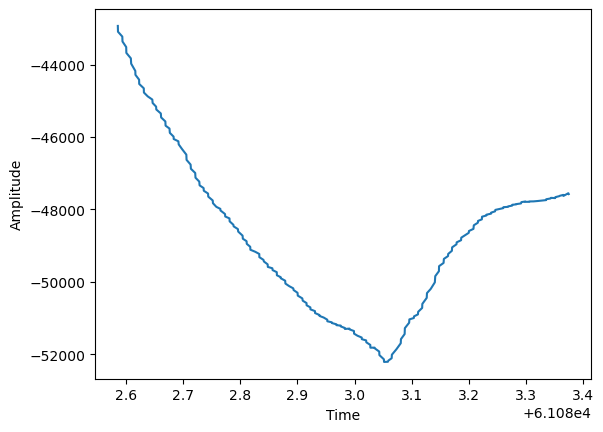

In [275]:
i_s = 0
i_e = 200

plt.plot(raw_EMG['eeg_time'][i_s:i_e], raw_EMG['eeg_data'][i_s:i_e, 0]);
plt.xlabel('Time')
plt.ylabel('Amplitude')

There is this strange latency problem I recorded with my Cyton (which has now been resolved). This will not be a problem with subsequent data collection -- Microsoft updated my Cyton's FTDI driver properties and introduced delays that I didn't catch until I generated the plot above.

Due to the nature of our data, it is possible that this will not have a significant effect on our final results, but we'll just have to see.

Let's plot a continous chunk of data without time to visualize the data more clearly

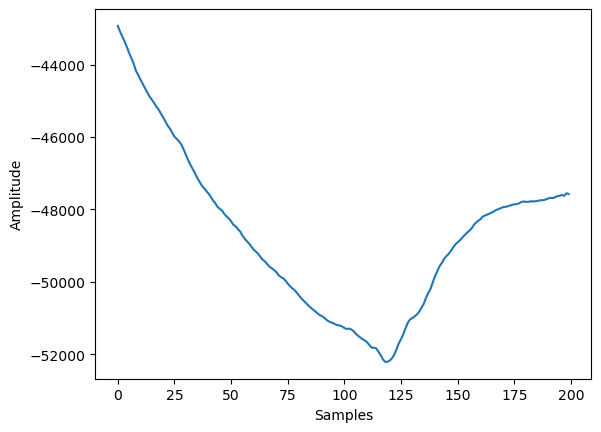

In [276]:
plt.plot(raw_EMG['eeg_data'][i_s:i_e, 0]);
plt.xlabel('Samples');
plt.ylabel('Amplitude');

## Step 2: Filter the data

I typically apply non-causal filters to my EEG data when I'm making BCIs since I typically make synchronous systems, but, since this is going to be an asynchronous system, applying a continuous filter makes sense. If we use wavelet analysis or some other time frequency analysis, we'll need to have larger chunks of data, but with standard filtering, we can arbitrarily break the data up into even single samples (although almost certainly we'll need something like 50 to 100 ms at the smallest I would guess)

We'll be applying an FIR filter. FIR filters have linear phase shift which means we'll have a constant delay that can be corrected for in a real-time system if we want. We could even incorporate this information in a modified Kalman filter that could control drone movements -- but that's beyond the current scope of the project.

FIR filters are also more stable than IIR filters. 

Causal means that the filter only relies on past (and the current) samples. This means that the filter is realizable or can be created in a real-time (digital or analog) system. Non-causal means the filter relies on past and future samples (which leads to a lot of convenient effects), but we won't worry about this for now.

We'll take a bandpass from 0.1 to 125 Hz. The sampling rate (fs) is 250 Hz and the maximum frequency we can obtain is $\frac{1}{2}$ of the sampling rate (Nyquist theorem). This means that all signals faster than 125 Hz are likely aliased and can be discarded.

We'll be using 101 time points in our coefficient. This means the filter will be subtly influenced by approximately 100 samples (400 ms) in the past. This can be made smaller as needed. We'll have to assess the trade offs.

In [277]:
coeffs = [0.1, 124.]
num_taps = 31
filt_EMG = ez.filt_cont(raw_EMG, coeffs, num_taps, 'bandpass', 'fir', causal=True)

Causal FIR Warning: Linear phase delay introduced.


Let's visualize the filtered portion of the same data

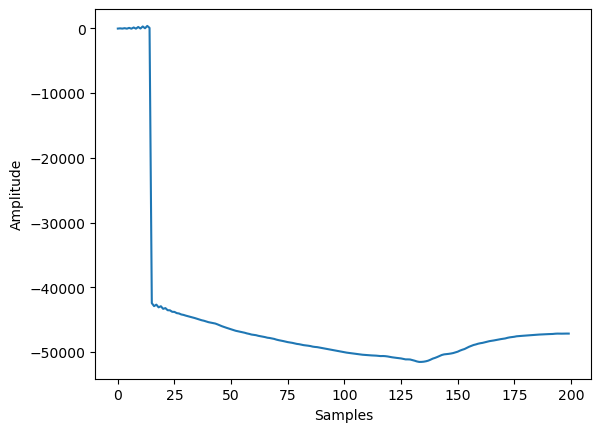

In [278]:
plt.plot(filt_EMG['eeg_data'][i_s:i_e, 0]);
plt.xlabel('Samples');
plt.ylabel('Amplitude');

Wow that looks pretty weird. Is that what you were expecting? The reason for this weird looking graph is because of our causal filtering. You can see that there's this inflection somewhere around 15 samples. This isn't a coincidence -- it's due to the number of coefficients in our FIR filter. Since our FIR filter is causal, there will be edge artifacts like these when the number of samples to process are smaller than the number of coefficients. It is common to simply discard or ignore these samples. In the real world, you'll always record a bit of unimportant data before you start making decisions even in real-time.

And let's skip a few samples and plot raw and filtered data over each other

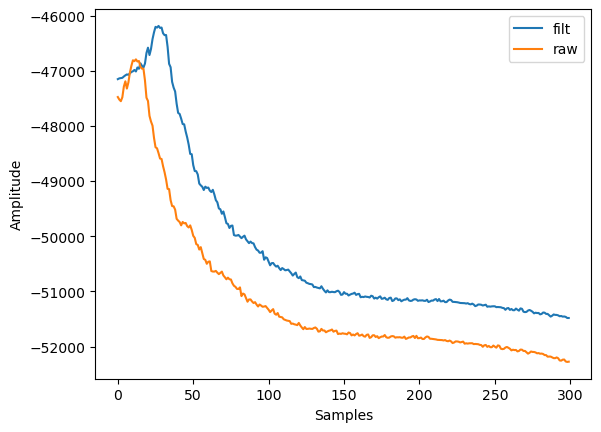

In [279]:
i_s = 200
i_e = 500
plt.plot(filt_EMG['eeg_data'][i_s:i_e, 0], label='filt');
plt.plot(raw_EMG['eeg_data'][i_s:i_e, 0], label='raw');
plt.xlabel('Samples');
plt.ylabel('Amplitude');
plt.legend(loc='best');

Notice how our filered (blue) data appears to be offset from our raw data? This is because of the constant phase delay introduced with our causal FIR filter. We can correct this simply offline by applying a non-causal filter, or by shifting samples back (num taps - 1 / 2). For now, we're going to keep the phase delay and accept it's part of the system.

## Step 3: Epoch

Epoching is the process of chunking the data, or extracting information relative to a certain event. This is very common in EEG research when you're dealing with event-related brain potentials (ERPs). It is also used in other BCIs for training classifiers such as with motor imagery. Although our final system will be trying to classify EMG in near-real time without knowledge of when exactly events occur, we need to collect data with this knowledge in order to efficiently calibrate our systems. In this case we're allowing the ML team to use supervised methods for dimensionality reduction and classification, which tend to perform better than unsupervised systems. Of course they're welcome to use unsupervised methods as well, but these labeled results will give us better visualizations in general and allow us to see larger trends with different movements.

It is common to take the average across all trials of a particular category, which we will also do here.

We want to extract relatively large chunks relative to the onset of our events, and we want to group similar events together. In the case of the paradigm I created after meeting with Tekin and Cassia, we decided on the 6 following classes:

1. ```C```: Closed hand / relaxed
2. ```U```: Hand up
3. ```T```: Thumb up
4. ```I```: Index Finger
5. ```M```: Middle Finger
6. ```R```: Ring Finger
7. ```P```: Pinky Finger

In the experiment I ran, each action was performed for approximately 4 beats at 120 bpm, a.k.a. 2 seconds. The experiment was designed such that ```O```, the relaxed position, was always in between any other movement, and the other movements were randomly determined. However, since we want to also classify the relaxed position, I decided to double its time to 8 beats (4 seconds). This means that for all states we can get a long section of time where the action is performed in full including the onset, continuous action, and offset. How much of this information will be useful is an open question that the ML team will explore.

In [280]:
# Epoch data
epoch_s = -300  # we want each epoch to start 300 ms before the onset
epoch_e = 2300 # and we want them to end 2.3 seconds after onset
C_mod   = 1000 # for "O" stimuli, we'll add 1 second to account for transitions to/from other states

epoch_C = ez.epoch(filt_EMG, 'C', epoch_s+C_mod, epoch_e+C_mod)
epoch_U = ez.epoch(filt_EMG, 'U', epoch_s, epoch_e)
epoch_T = ez.epoch(filt_EMG, 'T', epoch_s, epoch_e)
epoch_I = ez.epoch(filt_EMG, 'I', epoch_s, epoch_e)
epoch_M = ez.epoch(filt_EMG, 'M', epoch_s, epoch_e)
epoch_R = ez.epoch(filt_EMG, 'R', epoch_s, epoch_e)
epoch_P = ez.epoch(filt_EMG, 'P', epoch_s, epoch_e)

#for our purposes, we will need to change the markers to be our 8 types of movements, and we also have to
#change this part of the code to have epoch_ variables for each of our 8 movements

We now have our epoched EMG activity. However, we can't take the average or consider our processing done just yet. This is because our data still has a DC offset. What do I mean by this? Well let's try plotting all of the ```epoch_C``` data from a single channel on one graph

In [281]:
epoch_U['erp_data'].shape

(7, 650, 3)

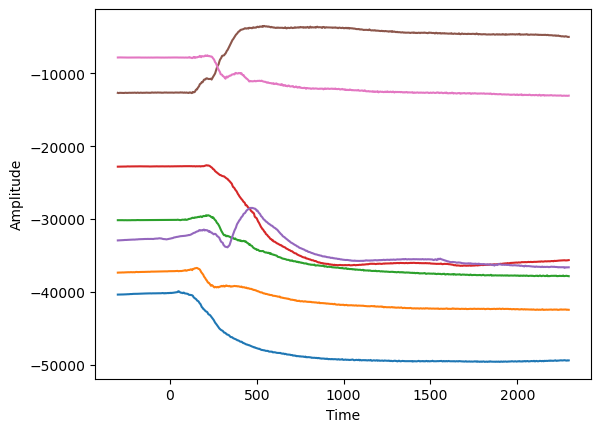

In [282]:
# Note the dimenions of "erp_data" are: (epochs x time points x channels)
plt.plot(epoch_U['erp_time'], epoch_U['erp_data'][:, :, 0].T);
plt.xlabel('Time');
plt.ylabel('Amplitude');

We can see that all of these patterns look similar, however, they start on different initial amplitude values and none of those are centered around 0. In the EEG world, when we generate these ERPs, we often perform an operation known as baseline correction. Essentially this is a process where we calculate the mean during a period of recent inactivity and subtract that from the rest of the activity. In real-time we can do this in a variety of ways or not do anything at all if post-processing takes normalizing/standardizing the data into account. What we'll do in this case is apply a baseline correction since we're captured a known period of relaxation before stimulus onset. This will allow us to visualize the patterns more clearly.

In [283]:
bl_s = -300 # ms
bl_e = -100 # ms


epoch_C = ez.baseline_correct(epoch_C, bl_s+C_mod, bl_e+C_mod)
epoch_U = ez.baseline_correct(epoch_U, bl_s, bl_e)
epoch_T = ez.baseline_correct(epoch_T, bl_s, bl_e)
epoch_I = ez.baseline_correct(epoch_I, bl_s, bl_e)
epoch_M = ez.baseline_correct(epoch_M, bl_s, bl_e)
epoch_R = ez.baseline_correct(epoch_R, bl_s, bl_e)
epoch_P = ez.baseline_correct(epoch_P, bl_s, bl_e)

#we will need to change this so that it is done for our 8 movements. Same with the rest of the code in this and 
# import_data.py/ipynb

Let's make the same plot above, but with our baseline corrected data

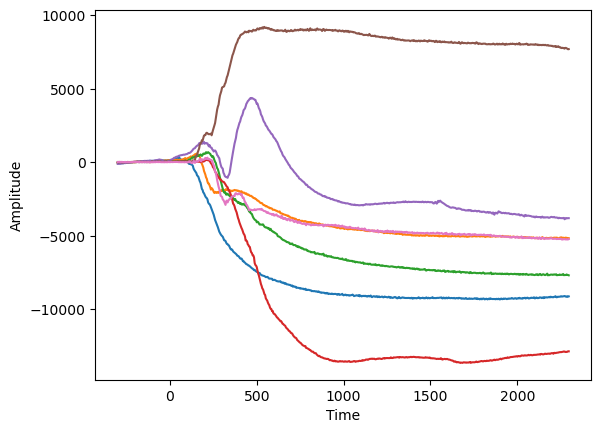

In [284]:
plt.plot(epoch_U['erp_time'], epoch_U['erp_data'][:, :, 0].T);
plt.xlabel('Time');
plt.ylabel('Amplitude');

Awesome. This will also allow us to visualize all three channels by giving us the ability to easily put them on different y-ticks

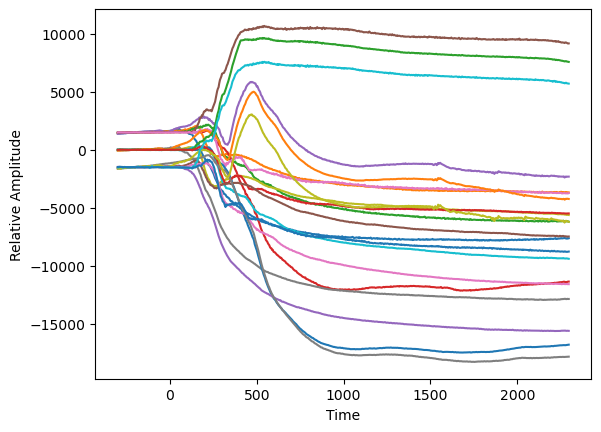

In [285]:
# Plot all 3 EMG channels on a single plot by scaling y values


plt.plot(epoch_U['erp_time'], epoch_U['erp_data'][:, :, 0].T + 1500); # Channel 1
plt.plot(epoch_U['erp_time'], epoch_U['erp_data'][:, :, 1].T);        # Channel 2
plt.plot(epoch_U['erp_time'], epoch_U['erp_data'][:, :, 2].T - 1500); # Channel 3
plt.xlabel('Time');
plt.ylabel('Relative Amplitude');

Even just that plot shows us some interesthing trends. It seems like channel 1 is encoding most of the clench information (which was the plan), while channel 2 encodes very little information and channel 3 is unreliable in encoding useful information. Of course these are large scale trends we're observing in amplitude space -- there are likely useful amounts of information in the variance and frequency domains that we cannot see currently.

## Step 4: Generate averaged figures

We can visualize trends more accurately by looking at grand averages. This will have a smoothing effect, which can be useful for assessing trends. I'm not going to explain the generation of these figures too much, but hopefully the figures themselves and the explanations above help in making the below code more clear.

In [286]:
# We'll make a quick function to plot all 3 channels on the same plot
def plot_3_chans(data, t, sep, title='', ax=None):
    if ax == None:
        raise Exception('Must provide axis object')
    
    vals = [-sep, 0, sep] # fixed to 3 values for now
    [ax.plot(t, data[:, i] + x) for i, x in enumerate(vals)];
    ax.set_yticks([-sep, 0, sep]);
    ax.set_yticklabels(['EMG1', 'EMG2', 'EMG3'])
    ax.set_xlabel('Time (ms)');
    ax.set_title(f'{title}');

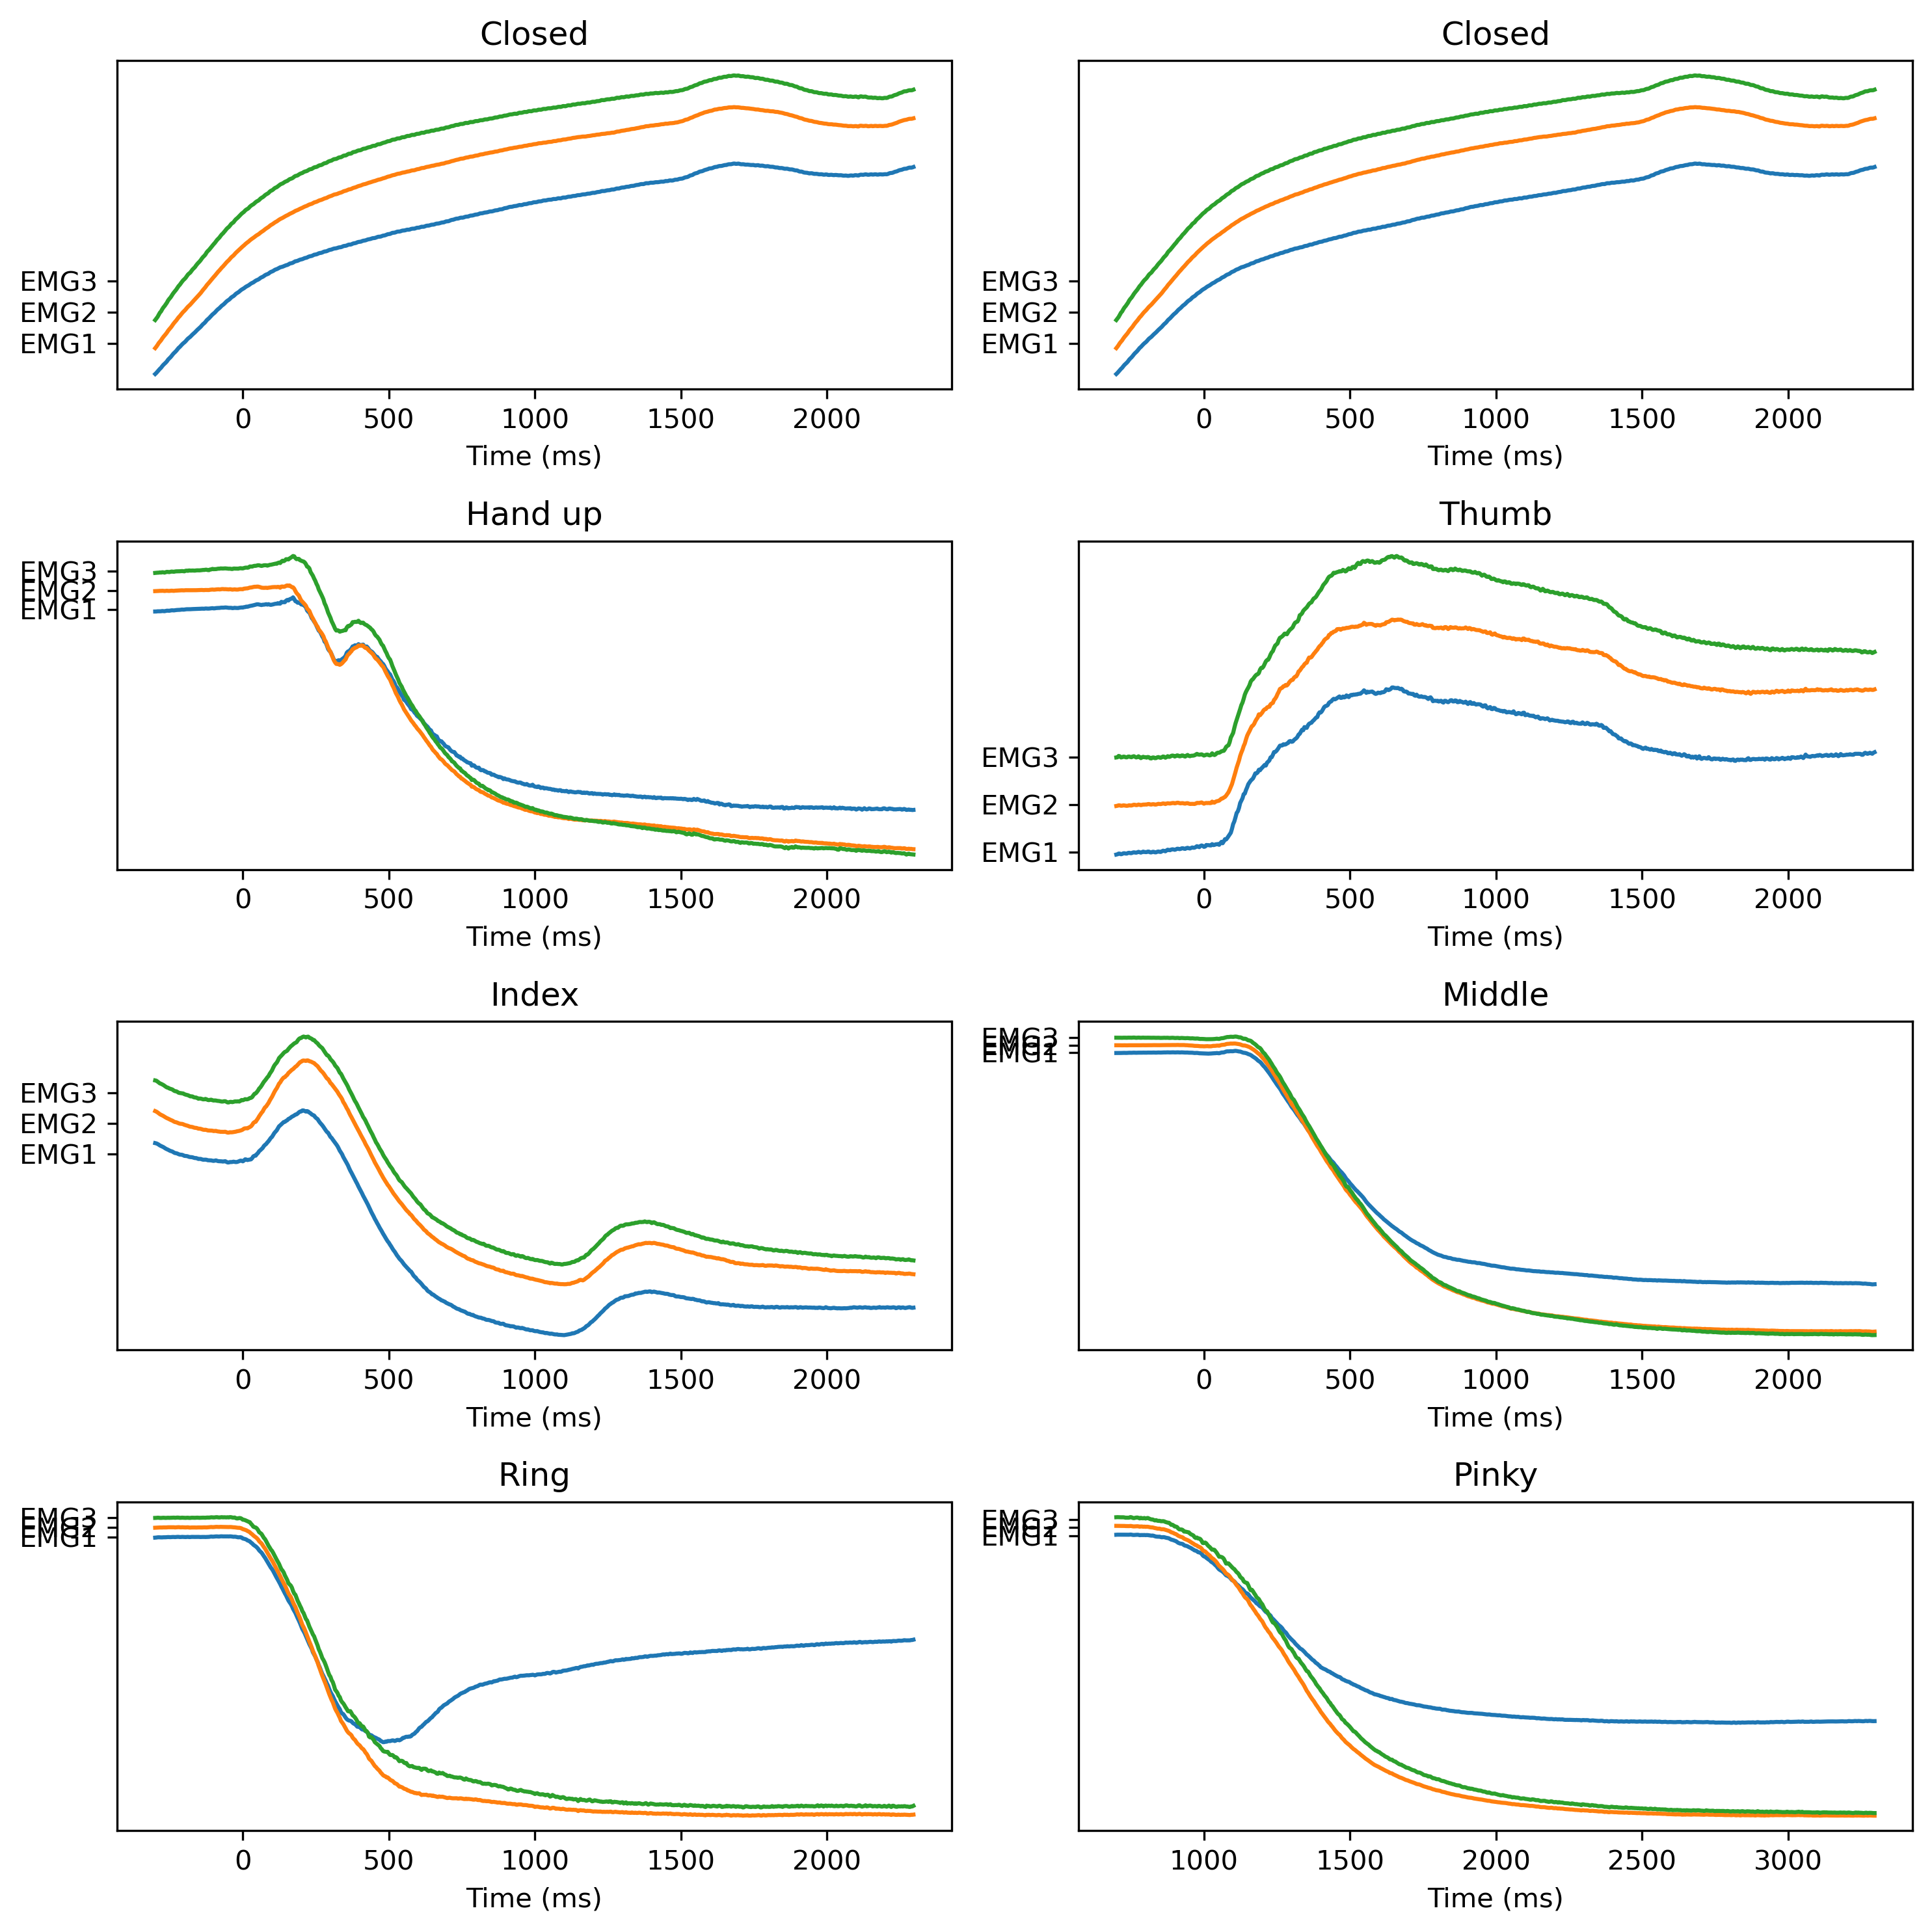

In [287]:
# Create averages across epochs
times   = epoch_U['erp_time'] # same for all except epoch_O
times_C = epoch_C['erp_time']

# returns num time points x channels
avg_C = np.mean(epoch_C['erp_data'], 0)
avg_U = np.mean(epoch_U['erp_data'], 0) 
avg_T = np.mean(epoch_T['erp_data'], 0) 
avg_I = np.mean(epoch_I['erp_data'], 0) 
avg_M = np.mean(epoch_M['erp_data'], 0) 
avg_R = np.mean(epoch_R['erp_data'], 0)
avg_P = np.mean(epoch_P['erp_data'], 0) 


# Let's create a subplot. We will need 6 plots in total so we can make it 2 cols by 3 rows
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 10), dpi=300)

plot_3_chans(avg_C, times,   500, 'Closed', ax[0, 0])
plot_3_chans(avg_C, times,   500, 'Closed', ax[0, 1])
plot_3_chans(avg_U, times,   500, 'Hand up', ax[1, 0])
plot_3_chans(avg_T, times,   500, 'Thumb', ax[1, 1])
plot_3_chans(avg_I, times,   500, 'Index', ax[2, 0])
plot_3_chans(avg_M, times,   500, 'Middle', ax[2, 1])
plot_3_chans(avg_R, times,   500, 'Ring', ax[3, 0])
plot_3_chans(avg_P, times_C, 500, 'Pinky', ax[3, 1])

fig.tight_layout()
plt.show()

Lookin' good!

## Step 5: Extract data for ML team

I wasn't given instructions on a format and this current data is pretty exploratory, so we'll just export our epoched data to a dict with other useful information.

In [288]:
# Function to 2D-ify our 3D epochs
def two_d_ify(data, label):
    obs, ts, chs = data.shape
    l = []
    for o in range(obs):
        for c in range(chs):
            #         label, observation, channel, all signals
            l.append([label, o,           c,       list(data[o, :, c])])

    return l

In [289]:
# Let's turn our 3D epochs into 2D DFs so that the ML team doesn't have to do it
# We'll export to a dict

export_dict = {s:{} for s in ['C', 'U', 'T', 'I', 'M', 'R', 'P']}

export_dict['C']['data'] = two_d_ify(epoch_C['erp_data'], 'C')
export_dict['C']['header'] = ['Label', 'Observation', 'Channel', list(times_C)]

export_dict['U']['data'] = two_d_ify(epoch_U['erp_data'], 'U')
export_dict['U']['header'] = ['Label', 'Observation', 'Channel', list(times)]

export_dict['T']['data'] = two_d_ify(epoch_T['erp_data'], 'T')
export_dict['T']['header'] = ['Label', 'Observation', 'Channel', list(times)]

export_dict['I']['data'] = two_d_ify(epoch_I['erp_data'], 'I')
export_dict['I']['header'] = ['Label', 'Observation', 'Channel', list(times)]

export_dict['M']['data'] = two_d_ify(epoch_M['erp_data'], 'M')
export_dict['M']['header'] = ['Label', 'Observation', 'Channel', list(times)]

export_dict['R']['data'] = two_d_ify(epoch_R['erp_data'], 'R')
export_dict['R']['header'] = ['Label', 'Observation', 'Channel', list(times)]

export_dict['P']['data'] = two_d_ify(epoch_P['erp_data'], 'P')
export_dict['P']['header'] = ['Label', 'Observation', 'Channel', list(times)]

export_dict['sampling_rate'] = raw_EMG['fs']
export_dict['original_file'] = fname

In [290]:
# Export data to a JSON
with open('EMG_hand_data.json', 'w', encoding='utf-8') as f:
    json.dump(export_dict, f, ensure_ascii=False, indent=4)